In [1]:
%%time
print('importing modules...')
import tensorflow as tf
import keras
import sys, os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from imageio import imread
from PIL import Image
from random import randint

sys.path.append(os.pardir)
from ssd_vgg16 import SSD
from utils import SSDUtils, convert_coordinates, sample_tensors

annotations = {'Car':100, 'Truck':100, 'Pedestrian':100, 'stop_sign':100}
fmap = {'conv4_3_norm': [1.0, 2.0, 1.0/2.0],
        'fc7': [1.0, 2.0, 3.0, 1.0/2.0, 1.0/3.0],
        'conv6_2': [1.0, 2.0, 3.0, 1.0/2.0, 1.0/3.0],
        'conv7_2': [1.0, 2.0, 3.0, 1.0/2.0, 1.0/3.0],
        'conv8_2': [1.0, 2.0, 1.0/2.0],
        'conv9_2': [1.0, 2.0, 1.0/2.0]}
input_shape = (300, 300, 3)

NUM_CLASSES = len(annotations) + 1
print('setting up model...')
model = SSD(input_shape, num_classes=NUM_CLASSES, fmap=fmap)
print('done.')

importing modules...


/home/hatta/.virtualenvs/Singleshot/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


setting up model...
Instructions for updating:
dim is deprecated, use axis instead
done.
CPU times: user 3.76 s, sys: 2.15 s, total: 5.92 s
Wall time: 3.09 s


In [2]:
%%time
# Make data and prepare for training
img_folderpath = '../data/img/'
csv_filepath = '../data/alldata.csv'

print('making data...')
csv = pd.read_csv(csv_filepath, index_col=0)

print('choosing files...')
use_imgfile_names = pd.Series()
for i in range(len(annotations)):
    tmp = csv.filename[csv.object.isin([[x for x in annotations.keys()][i]])].sample(n=[v for v in annotations.values()][i])
    use_imgfile_names = use_imgfile_names.append(tmp)

print('reading image files...')
imagesize_list = []
for name in use_imgfile_names:
    try:
        im = Image.open(img_folderpath + name)
        t = list(im.size)
        t.insert(0,name)
        imagesize_list.append(t)
    except FileNotFoundError:
        pass

print('generating data...')
csv = csv[csv.filename.isin(use_imgfile_names) & csv.object.isin(annotations.keys())]
imgsize = pd.DataFrame(imagesize_list).rename(index=str, columns={0:'filename', 1:'w', 2:'h'})
df = pd.merge(csv, imgsize)
df.xmin /= df.w
df.ymin /= df.h
df.xmax /= df.w
df.ymax /= df.h
df['bounding_box'] = df[['xmin','ymin','xmax','ymax']].values.tolist()
one_hot_category = []
for i,row in df.iterrows():
    one_hot = [0] * len(annotations)
    category_position = [k for k,val in enumerate(annotations) if val == row.object][0]
    one_hot[category_position] = 1
    one_hot_category.append(one_hot)
df['one_hot_category'] = one_hot_category
df['one_hot_vector'] = df.one_hot_category + df.bounding_box
df = pd.DataFrame(df.groupby(['filename','w','h']).one_hot_vector.apply(list)).reset_index()

print('encoding...')
gtlabels = dict()
for i,row in df.iterrows():
    gtlabels[row.filename] = np.array(row.one_hot_vector)

print('done.')

making data...
choosing files...
reading image files...
generating data...
encoding...
done.
CPU times: user 1.11 s, sys: 27.1 ms, total: 1.14 s
Wall time: 1.14 s


In [3]:
%%time
# subsample weights (optional)
print("subsampling weights...")

import h5py
import numpy as np
import shutil

weights_source_path = '../trained_weights/VGG_coco_SSD_300x300_iter_400000.h5'
weights_destination_path = '../trained_weights/VGG_coco_SSD_300x300_iter_400000_subsampled_4_classes.h5'
shutil.copy(weights_source_path, weights_destination_path)
weights_source_file = h5py.File(weights_source_path, 'r')
weights_destination_file = h5py.File(weights_destination_path)

from utils import sample_tensors
classifier_names = ['conv4_3_norm_mbox_conf',
                    'fc7_mbox_conf',
                    'conv6_2_mbox_conf',
                    'conv7_2_mbox_conf',
                    'conv8_2_mbox_conf',
                    'conv9_2_mbox_conf']
n_classes_source = 81 # MSCOCO
classes_of_interest = [0, 3, 8, 1, 12] # ['background', 'car', 'truck', 'pedestrian', stop_sign']

for name in classifier_names:
    kernel = weights_source_file[name][name]['kernel:0'].value
    bias = weights_source_file[name][name]['bias:0'].value
    height, width, in_channels, out_channels = kernel.shape
    subsampling_indices = []
    for i in range(int(out_channels/n_classes_source)):
        indices = np.array(classes_of_interest) + i * n_classes_source
        subsampling_indices.append(indices)
    subsampling_indices = list(np.concatenate(subsampling_indices))
    new_kernel, new_bias = sample_tensors(weights_list=[kernel, bias],
                                          sampling_instructions=[height, width, in_channels, subsampling_indices],
                                          axes=[[3]], # The one bias dimension corresponds to the last kernel dimension.
                                          init=['gaussian', 'zeros'],
                                          mean=0.0,
                                          stddev=0.005)
    del weights_destination_file[name][name]['kernel:0']
    del weights_destination_file[name][name]['bias:0']
    weights_destination_file[name][name].create_dataset(name='kernel:0', data=new_kernel)
    weights_destination_file[name][name].create_dataset(name='bias:0', data=new_bias)

print("done.")

subsampling weights...
done.
CPU times: user 99 ms, sys: 202 ms, total: 301 ms
Wall time: 457 ms


In [4]:
%%time
# training config

print("loading and configuring weights...")
weights_destination_path = '../trained_weights/VGG_coco_SSD_300x300_iter_400000_subsampled_4_classes.h5'
model.load_weights(weights_destination_path, by_name=True)
freeze = ['data', 'conv1_1', 'conv1_2', 'pool1',
          'conv2_1', 'conv2_2', 'pool2',
          'conv3_1', 'conv3_2', 'conv3_3', 'pool3']
for L in model.layers:
    if L.name in freeze:
        L.trainable = False


print("initializing generator...")
from utils import SSDUtils
batch_size = 16
bboxutils = SSDUtils(model=model,
                     fmap=fmap,
                     input_shape=input_shape,
                     img_folderpath=img_folderpath,
                     gtlabels=gtlabels,
                     trainvalratio=0.8)

"""
print("compiling a loss function...")
from loss import MultiboxLoss
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)
model.compile(optimizer=optim, metrics=['acc'],
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss)


print("defining callbacks...")
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard
log_folderpath = '../logs/%s/' % 'test'
os.mkdir(log_folderpath)
callbacks = [ModelCheckpoint('checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                             verbose=1, save_weights_only=True),
             EarlyStopping(monitor='val_loss', min_delta=0,
                           patience=3, verbose=1, mode='auto'),
             LearningRateScheduler(lambda epoch, decay=0.9: base_lr * decay**(epoch)),
             TensorBoard(log_dir=log_folderpath, histogram_freq=0,
                         write_graph=True, write_grads=True, write_images=True)]
"""
print("done.")

loading and configuring weights...
initializing generator...
done.
CPU times: user 899 ms, sys: 1.3 s, total: 2.2 s
Wall time: 2.12 s


In [ ]:
# train
epochs = 100
history = model.fit_generator(generator=ssdutility.generate(train=True),
                              steps_per_epoch=ssdutility.train_batches,
                              epochs=epochs,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=ssdutility.generate(train=False),
                              validation_steps=ssdutility.val_batches,
                              workers=1)

In [5]:
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
inputs = []
images = []
img_path = '../data/img/1479498723489426594.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
img_path = '../data/img/1479498408460147688.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
img_path = '../data/img/stop_sign-005.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
img_path = '../data/img/stop_sign-179.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
img_path = '../data/img/1479498707988131043.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [6]:
%%time
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bboxutils.decode(preds)

5/5 [==============================] - 2s 419ms/step
decoding...
non-maximum-suppression...
conf-thresh
conf-thresh
conf-thresh
conf-thresh
conf-thresh
CPU times: user 25.6 s, sys: 713 ms, total: 26.3 s
Wall time: 25.9 s


-74 91 190 922 [0. 0. 0. 0.]
-474 30 173 1005 [0. 0. 0. 0.]
-508 257 -60 977 [0. 0. 0. 0.]
-476 -127 177 686 [0. 0. 0. 0.]


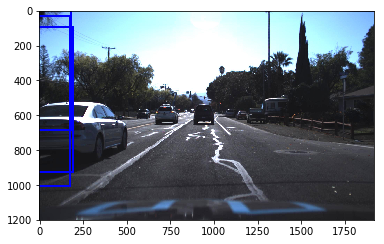

893 314 1590 727 [0.]


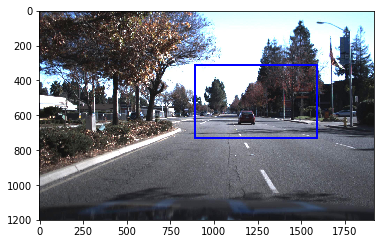

-156 -145 118 115 [3.]


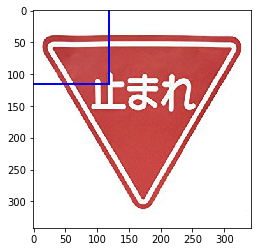

94 136 1050 923 [0. 0. 0. 0. 0.]
209 136 1364 919 [0. 0. 0. 0. 0.]
388 -60 1183 846 [0. 0. 0. 0. 0.]
-99 314 894 999 [0. 0. 0. 0. 0.]
86 311 1416 991 [0. 0. 0. 0. 0.]


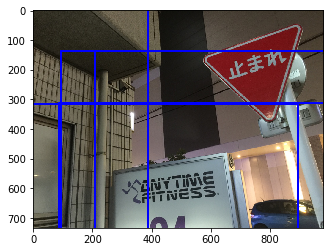

495 11 1461 832 [0.]


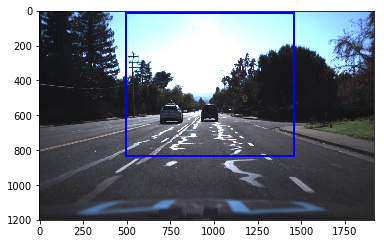

CPU times: user 2.11 s, sys: 1.99 s, total: 4.1 s
Wall time: 2 s


In [8]:
%%time
from utils import convert_coordinates
for i, img in enumerate(images):
    results[i][:,-4:] = convert_coordinates(results[i][:,-4:],conversion='centroids2corners')
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]
    
    # Get detections with confidence higher than 0.6.
    # top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(det_conf.shape[0]):
        xmin = int(round(det_xmin[i] * img.shape[1]))
        ymin = int(round(det_ymin[i] * img.shape[0]))
        xmax = int(round(det_xmax[i] * img.shape[1]))
        ymax = int(round(det_ymax[i] * img.shape[0]))
        print(xmin,ymin,xmax,ymax,det_label)
        
        score = det_conf[i]
        #label = int(det_conf)
        #label_name = annotations[label]
        #display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, color='b', linewidth=2))
        #currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

In [13]:
results

[array([[ 0.        ,  0.94840908, -0.08799298, -0.30794202,  0.0109661 ,
          0.46004719],
        [ 0.        ,  0.88493109, -0.2919856 , -0.39373235, -0.2020166 ,
          0.44389056],
        [ 0.        ,  0.82498771, -0.24915074, -0.19243193, -0.28023943,
          0.62153664],
        [ 0.        ,  0.81630045, -0.29373911, -0.39152159, -0.20165786,
          0.18006453]]),
 array([[ 0.        ,  0.6035825 ,  0.05120754, -0.04114618,  0.8791069 ,
          0.56428751]]),
 array([], shape=(0, 6), dtype=float64),
 array([], shape=(0, 6), dtype=float64),
 array([], shape=(0, 6), dtype=float64)]

In [6]:
bboxutils.defboxes.shape

(8732, 4)